<a href="https://colab.research.google.com/github/victorsobottka/bse-thesis-synthetic-data/blob/main/1_Deepseek_Yahoo_Finance_Fine_Part1_Tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈Generating Synthetic Data using Deepseek - Yahoo Finance

## **🔧 Environment Configuration**

In [ ]:
# STEP 1: Install dependencies
!pip install -q yfinance transformers accelerate
!pip -q install -U bitsandbytes
!pip -q install datasets




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# STEP 2: Download NVIDIA stock data
import yfinance as yf
import pandas as pd

import json
from datetime import datetime, timedelta

# **💾 Connect to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **📅 Dataset Download**

In [ ]:
"""
df_nvda = yf.download("NVDA", start="2020-01-01", end="2022-01-01")
df_nvda = df_nvda[["Open", "High", "Low", "Close", "Volume"]].round(2)

# Show first few rows
print("✅ Sample NVIDIA data:")
print(df_nvda.head(10))

# Step 4: Save to CSV
output_path = "/content/drive/MyDrive/Colab Notebooks/thesis/nvidia_2020_2021.csv"
df_nvda.to_csv(output_path)
print(f"💾 File saved to: {output_path}")
"""

'\ndf_nvda = yf.download("NVDA", start="2020-01-01", end="2022-01-01")\ndf_nvda = df_nvda[["Open", "High", "Low", "Close", "Volume"]].round(2)\n\n# Show first few rows\nprint("✅ Sample NVIDIA data:")\nprint(df_nvda.head(10))\n\n# Step 4: Save to CSV\noutput_path = "/content/drive/MyDrive/Colab Notebooks/thesis/nvidia_2020_2021.csv"\ndf_nvda.to_csv(output_path)\nprint(f"💾 File saved to: {output_path}")\n'

## 📄 **Read the file**

In [ ]:
import pandas as pd

# Load the data
file_path = "/content/drive/MyDrive/Colab Notebooks/thesis/nvidia_2020_2021.csv"
df_nvda = pd.read_csv(file_path, skiprows=[1, 2], header=0)
df_nvda.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]

number_of_rows = 10

# Display the first x rows
print(df_nvda.head(number_of_rows))

# Define output file
output_file = "/content/drive/MyDrive/Colab Notebooks/thesis/deepseek_train.jsonl"

         Date  Open  High   Low  Close     Volume
0  2020-01-02  5.94  5.97  5.89   5.97  237536000
1  2020-01-03  5.85  5.92  5.83   5.88  205384000
2  2020-01-06  5.78  5.91  5.76   5.90  262636000
3  2020-01-07  5.93  6.02  5.88   5.97  314856000
4  2020-01-08  5.97  6.03  5.93   5.98  277108000
5  2020-01-09  6.07  6.12  6.00   6.05  255112000
6  2020-01-10  6.16  6.19  6.07   6.08  316296000
7  2020-01-13  6.17  6.30  6.14   6.27  319840000
8  2020-01-14  6.23  6.26  6.14   6.16  359088000
9  2020-01-15  6.17  6.19  6.09   6.11  263104000


## **💬 Build the prompt**

In [ ]:
examples = []
window_size = 10
forecast_size = 50

In [ ]:
max_examples = 500

with open(output_file, "w") as f:
    for i in range(min(len(df_nvda) - window_size - forecast_size, max_examples)):
        context = df_nvda.iloc[i:i+window_size][["Date", "Close"]].to_csv(index=False, header=False)
        target = df_nvda.iloc[i+window_size:i+window_size+forecast_size][["Date", "Close"]].to_csv(index=False, header=False)

        prompt = (
            f"Here are {window_size} real NVIDIA stock price rows in CSV format (Date,Close):\n"
            f"{context}\n"
            f"Now generate {forecast_size} synthetic daily stock prices for NVIDIA.\n"
            "Each row must be: YYYY-MM-DD,Close\n"
            "Only output pure CSV lines.\n"
            "Format: CSV with no headers. Use YYYY-MM-DD format.\n"
            "This is not a coding task.\n"
            "Do NOT return code, explanation, or comments.\n"
            "Start the data output now:\n"
        )
        full_text = prompt + target
        f.write(json.dumps({"text": full_text}) + "\n")


#**🐋 Load DeepSeek Model using Hugging Face 🤗**

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
# To solve error with bits and bytes
from transformers import BitsAndBytesConfig
import torch

model_name = "deepseek-ai/deepseek-llm-7b-base"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_threshold=6.0
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,
    trust_remote_code=True
)

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

## **🏋️ Train the model**

In [ ]:
from datasets import load_dataset

dataset = load_dataset("json", data_files=output_file)
dataset = dataset["train"].train_test_split(test_size=0.1)

# def tokenize_function(examples):
#    return tokenizer(examples["text"], truncation=True, max_length=2048)

def tokenize_function(example):
    tokens = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",   # ⚠️ importante para evitar errores
        max_length=2048
    )
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens



tokenized = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

training_args = TrainingArguments(
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=2e-5,
    fp16=True,
    save_total_limit=2,
    logging_steps=10,
    output_dir="/content/drive/MyDrive/Colab Notebooks/thesis/deepseek-lora-finance",
    logging_dir = "/content/drive/MyDrive/Colab Notebooks/thesis/logs",
    save_strategy="steps",
    save_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer
)

trainer.train()


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

<ipython-input-9-6ce9b4774eeb>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, 

Step,Training Loss
10,7.622100
20,7.451100
30,7.228000
40,6.931500
50,6.607200
60,6.192400
70,5.720100
80,5.208900
90,4.640100
100,4.037500


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/

TrainOutput(global_step=150, training_loss=4.99547799428304, metrics={'train_runtime': 4641.5398, 'train_samples_per_second': 0.259, 'train_steps_per_second': 0.032, 'total_flos': 9.57707175591936e+16, 'train_loss': 4.99547799428304, 'epoch': 3.0})

## **🎵 Load Fine Tuned Model**

In [ ]:
import os

base_path = "/content/drive/MyDrive/Colab Notebooks/thesis/deepseek-lora-finance"
checkpoints = [f for f in os.listdir(base_path) if f.startswith("checkpoint")]
checkpoints.sort(key=lambda x: int(x.split("-")[-1]))
last_checkpoint = os.path.join(base_path, checkpoints[-1])

from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_enable_fp32_cpu_offload=True  # ⚠️ Permite usar CPU en módulos que no entren en GPU
)

from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

base_model = AutoModelForCausalLM.from_pretrained(
    "deepseek-ai/deepseek-llm-7b-base",
    device_map="auto",  # puede repartir entre CPU/GPU
    quantization_config=bnb_config,
    trust_remote_code=True,
    torch_dtype=torch.float16
)



model = PeftModel.from_pretrained(base_model, last_checkpoint)
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-llm-7b-base", trust_remote_code=True)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

##**🤖 Generate Synthetic Data**

In [ ]:
context = df_nvda.tail(10)[["Date", "Close"]].to_csv(index=False, header=False)

prompt = (
    "Here are 10 real NVIDIA stock price rows in CSV format (Date,Close):\n"
    f"{context}\n"
    "Now generate the following 30 simulate daily stock prices for NVIDIA.\n"
    "Each row must be: YYYY-MM-DD,Close\n"
    "Only output pure CSV lines.\n"
    "Format: CSV with no headers. Use YYYY-MM-DD format.\n"

    "Start the data output now:\n"
)


In [ ]:
import torch

inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=600,
        temperature=0.7,
        top_p=0.95,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)


Here are 10 real NVIDIA stock price rows in CSV format (Date,Close):
2021-12-17,27.75
2021-12-20,27.67
2021-12-21,29.02
2021-12-22,29.35
2021-12-23,29.59
2021-12-27,30.89
2021-12-28,30.27
2021-12-29,29.95
2021-12-30,29.53
2021-12-31,29.36

Now generate the following 30 simulate daily stock prices for NVIDIA.
Each row must be: YYYY-MM-DD,Close
Only output pure CSV lines.
Format: CSV with no headers. Use YYYY-MM-DD format.
Start the data output now:

A: Here is an approach using pandas.
import pandas as pd

# set up the dates
dates = pd.date_range('2021-12-17', periods=30, freq='D')

# set up the close prices
close = pd.Series(range(30), index=dates)

# print the close prices to the console
print(close)


A: You can use pandas:
import pandas as pd

data = pd.read_csv('data.csv', index_col=0, parse_dates=True, 
                  date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'))

data['new'] = data['Close'].shift(1)

print(data.head())

Output:
        Close   new
Date
2021-12-17

##**📉 Visualization**

         Date  Close
0  2021-12-17  27.75
1  2021-12-20  27.67
2  2021-12-21  29.02
3  2021-12-22  29.35
4  2021-12-23  29.59
5  2021-12-27  30.89
6  2021-12-28  30.27
7  2021-12-29  29.95
8  2021-12-30  29.53
9  2021-12-31  29.36
10 2021-12-16  27.75
11 2021-12-17  27.67
12 2021-12-18  29.02
13 2021-12-19  29.35
14 2021-12-20  29.59
15 2021-12-21  30.89
16 2021-12-22  30.27
17 2021-12-23  30.59
18 2021-12-24  30.37
19 2021-12-25  30.31
20 2021-12-26  30.09
21 2021-12-27  30.26
22 2021-12-28  30.22
23 2021-12-29  29.95
24 2021-12-30  29.53
25 2021-12-31  29.36


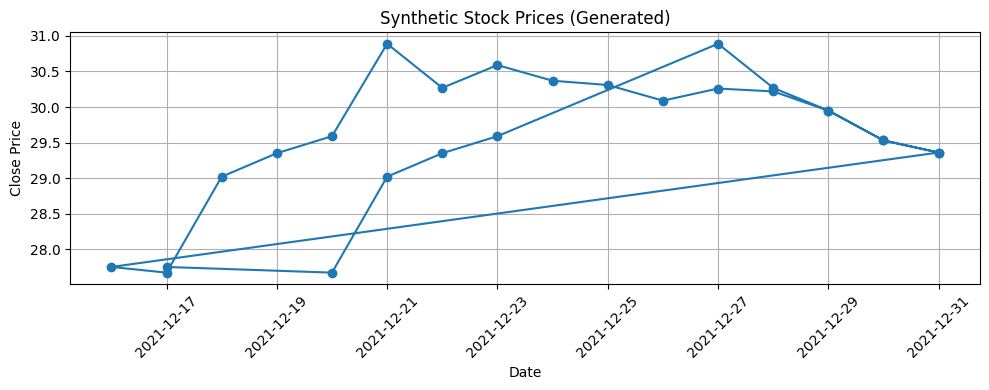

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from io import StringIO


# Extraer solo las líneas CSV válidas: YYYY-MM-DD,decimal
csv_lines = [line for line in generated_text.splitlines() if re.match(r"^\d{4}-\d{2}-\d{2},\d+(\.\d+)?$", line)]

# Convertir a DataFrame
df = pd.read_csv(StringIO("\n".join(csv_lines)), names=["Date", "Close"])
df["Date"] = pd.to_datetime(df["Date"])
df["Close"] = df["Close"].astype(float)

print(df)

# Graficar
plt.figure(figsize=(10, 4))
plt.plot(df["Date"], df["Close"], marker="o")
plt.title("Synthetic Stock Prices (Generated)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## **Deprecated**

In [ ]:
# STEP 5: Generate synthetic stock data
import torch

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=4000,
        temperature=0.7,
        top_p=0.95,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
generated_csv = generated_text.split("Now generate 10 new days of synthetic stock data:")[-1].strip()

print("🧠 Generated synthetic stock CSV:")
print(generated_csv)


🧠 Generated synthetic stock CSV:
Here are 10 real NVIDIA stock price rows in CSV format (Date,Close):

2020-01-02,5.97
2020-01-03,5.88
2020-01-06,5.9
2020-01-07,5.97
2020-01-08,5.98
2020-01-09,6.05
2020-01-10,6.08
2020-01-13,6.27
2020-01-14,6.16
2020-01-15,6.11

Now generate 100 synthetic daily stock prices for NVIDIA.
Each row must be: YYYY-MM-DD,Close
Only output pure CSV lines.
Format: CSV with no headers. Use YYYY-MM-DD format.
Do NOT return code, markdown, explanation, or headers.
This is not a coding task.
Start the data output now:

2020-01-02,5.97
2020-01-03,5.88
2020-01-04,5.9
2020-01-05,5.97
2020-01-06,5.98
2020-01-07,5.99
2020-01-08,6.0
2020-01-09,6.05
2020-01-10,6.06
2020-01-11,6.07
2020-01-12,6.08
2020-01-13,6.15
2020-01-14,6.16
2020-01-15,6.17
2020-01-16,6.2
2020-01-17,6.23
2020-01-18,6.27
2020-01-19,6.28
2020-01-20,6.29
2020-01-21,6.3
2020-01-22,6.31
2020-01-23,6.36
2020-01-24,6.37
2020-01-25,6.4
2020-01-26,6.42
2020-01-27,6.43
2020-01-28,6.44
2020-01-29,6.45
2020-01-30,

##**🪟 Parse output into DataFrame**

In [ ]:
from io import StringIO
import pandas as pd
import re

# 1. Extract only valid rows: starts with YYYY-MM-DD and has 2 columns
lines = []
for line in generated_csv.splitlines():
    line = line.strip()
    if re.match(r"^\d{4}-\d{2}-\d{2},", line):
        parts = line.split(",")
        if len(parts) == 2:
            try:
                float(parts[1])  # Close value
                lines.append(line)
            except ValueError:
                continue

# 2. Check number of rows captured
print(f"✅ {len(lines)} valid rows captured.")

# 3. Parse into DataFrame
cleaned_csv = "\n".join(lines)

df_synthetic = pd.read_csv(StringIO(cleaned_csv), header=None, names=["Date", "Close"])
df_synthetic["Date"] = pd.to_datetime(df_synthetic["Date"])

print("📊 Parsed synthetic DataFrame:")
df_synthetic.head()


✅ 261 valid rows captured.
📊 Parsed synthetic DataFrame:


,Date,Close
0,2020-01-02,5.97
1,2020-01-03,5.88
2,2020-01-06,5.90
3,2020-01-07,5.97
4,2020-01-08,5.98


## **📉 Visualize the results**

In [ ]:
df_real = df_nvda.copy()
df_real.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]

df_real.head()

df_real["Date"] = pd.to_datetime(df_real["Date"])
df_synthetic["Date"] = pd.to_datetime(df_synthetic["Date"])


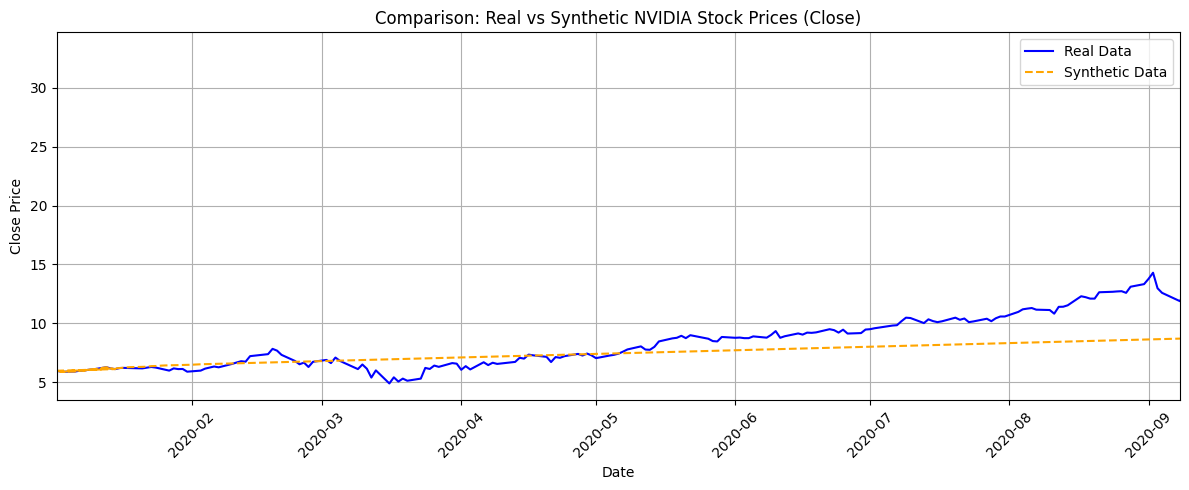

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Serie real
plt.plot(df_real["Date"], df_real["Close"], label="Real Data", color="blue")

# Serie sintética
plt.plot(df_synthetic["Date"], df_synthetic["Close"], label="Synthetic Data", color="orange", linestyle="--")

plt.title("Comparison: Real vs Synthetic NVIDIA Stock Prices (Close)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.xlim(df_real["Date"].min(), df_synthetic["Date"].max())

plt.tight_layout()
plt.show()

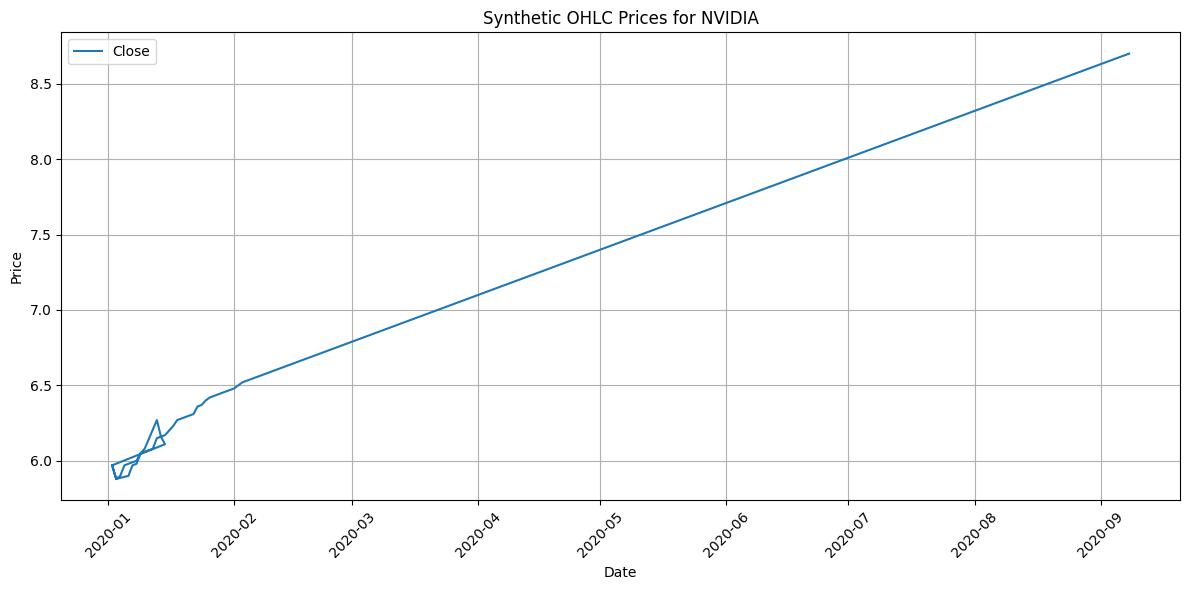

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for col in ["Close"]:
    plt.plot(df_synthetic["Date"], df_synthetic[col], label=col)

plt.title("Synthetic OHLC Prices for NVIDIA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
